In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import emachine as EM

from sklearn.preprocessing import OneHotEncoder

In [2]:
np.random.seed(0)

In [3]:
def generate_interactions(n,m,g,sp,i1i2):
    nm = n*m
    w = np.random.normal(0.0,g/np.sqrt(nm),size=(nm,nm))
    
    # sparse
    for i in range(n):
        i1,i2 = i1i2[i,0],i1i2[i,1]
        for j in range(n):
            j1,j2 = i1i2[j,0],i1i2[j,1]
            if (np.abs(j-i) > 1) and (np.random.rand() < sp): 
                w[i1:i2,j1:j2] = 0.
    
    # sum_j wji to each position i = 0                
    for i in range(n):        
        i1,i2 = i1i2[i,0],i1i2[i,1]             
        w[:,i1:i2] -= w[:,i1:i2].mean(axis=1)[:,np.newaxis]            

    # no self-interactions
    for i in range(n):
        i1,i2 = i1i2[i,0],i1i2[i,1]
        w[i1:i2,i1:i2] = 0.   # no self-interactions

    # symmetry
    for i in range(nm):
        for j in range(nm):
            if j > i: w[i,j] = w[j,i]       
        
    return w

In [4]:
def ops_w_true(s,n_var,w_true):
    #input: s[n_seq, n_var*m]: one hot   
    n_seq,nm = s.shape
    m = int(nm/float(n_var)) # numer of categories at each position

    n_linear = int((m-1)*n_var)
    n_quad = int(((m-1)**2)*n_var*(n_var-1)/2.)
    n_ops = n_linear + n_quad
        
    ops = np.zeros((n_seq,n_ops))
    w_true_ops = np.zeros(n_ops)
    ij_tab = np.zeros((n_ops,2))
    
    iops = 0
    # linear terms    
    for i in range(n_var):
        i1,i2 = i1i2[i,0],i1i2[i,1]
        for ia in range(i1,i2-1):
            ops[:,iops] = (s[:,ia] - s[:,i2-1])
            w_true_ops[iops] = 0. # set bias_true = 0 for simulation data                        
            iops += 1
    
    # quadratic terms
    for i in range(n_var-1):
        i1,i2 = i1i2[i,0],i1i2[i,1]
        for j in range(i+1,n_var):
            j1,j2 = i1i2[j,0],i1i2[j,1]
            for ia in range(i1,i2-1):
                for jb in range(j1,j2-1):
                    ops[:,iops] = (s[:,ia] - s[:,i2-1])*(s[:,jb] - s[:,j2-1])
                    w_true_ops[iops] = w_true[ia,jb]
                    
                    ij_tab[iops,0] = ia
                    ij_tab[iops,1] = jb
                                        
                    iops += 1
                        
    return ops,w_true_ops,ij_tab

In [5]:
def generate_seq(w_true,n_seq,n_var,m,n_sample=30):
    samples = np.random.choice(np.arange(m),size=(n_seq*n_sample,n_var),replace=True)

    onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
    s = onehot_encoder.fit_transform(samples)

    ops,w_true_ops,ij_tab = ops_w_true(s,n_var,w_true)
    energy = ops.dot(w_true_ops)# linear and quadratic

    p = np.exp(energy)
    p /= np.sum(p)

    out_samples = np.random.choice(np.arange(n_seq*n_sample),size=n_seq,replace=True,p=p)

    #return samples[out_samples],w_true_ops
    return ops[out_samples],w_true_ops,ij_tab

In [6]:
def fit(ops,n_var,m,eps=0.1,max_iter=100,alpha=0.1):    
    n_linear = int((m-1)*n_var)
    n_quad = int(((m-1)**2)*n_var*(n_var-1)/2.)
    
    cov = np.hstack([np.full(n_linear,2./m),np.full(n_quad,4./(m**2))])
    
    E_av = np.zeros(max_iter)
    n_ops = ops.shape[1]

    np.random.seed(13)
    w = np.random.rand(n_ops)-0.5    
    for i in range(max_iter):              
        #energies_w = energy_ops(ops,w)
        energies_w = ops.dot(w)        
        energies_max = energies_w.max()
        
        # to avoid a too lager value:
        probs_w = np.exp((energies_w-energies_max)*(eps-1)) 
        z_data = np.sum(probs_w)
        probs_w /= z_data
        ops_expect_w = np.sum(probs_w[:,np.newaxis]*ops,axis=0)

        E_av[i] = energies_w.mean()  
        w += alpha*(ops_expect_w - eps*w*cov)
      
    return w,-E_av[-1]

In [7]:
n = 10; m = 4; g = 2. ; sp = 0.0

#mx = np.array([len(np.unique(s0[:,i])) for i in range(n)])
mx = np.array([m for i in range(n)])
mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T 

w_true = generate_interactions(n,m,g,sp,i1i2)

#plt.imshow(w_true,cmap='rainbow',origin='lower')

In [8]:
n_seq = 10000
n_sample = 30
n_var = n

In [9]:
ops,w_true_ops,ij_tab = generate_seq(w_true,n_seq,n_var,m,n_sample=30)

In [10]:
n_ops = ops.shape[1]
n_linear = n_var*(m-1)
n_quad = n_ops - n_linear

eps_list = np.linspace(0.05,0.15,3)
E_eps = np.zeros(len(eps_list))
w_eps = np.zeros((len(eps_list),n_ops))
for i,eps in enumerate(eps_list):
    w_eps[i,:],E_eps[i] = fit(ops,n_var,m,eps=eps,max_iter=100)
    print(eps,E_eps[i])

0.05 -5.140193911723748
0.1 -5.105426000415221
0.15 -5.094837286854179


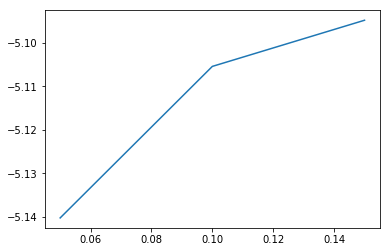

In [11]:
plt.plot(eps_list,E_eps)

In [12]:
ieps = np.argmax(E_eps)
w_pred = w_eps[ieps]
print('optimal eps:', eps_list[ieps])

optimal eps: 0.15


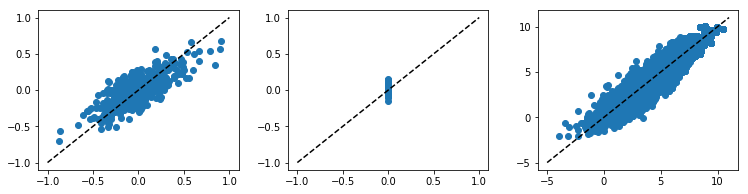

In [13]:
nx,ny = 3,1
nfig = nx*ny
fig, ax = plt.subplots(ny,nx,figsize=(nx*3.5,ny*2.8))

# linear and quadratic
ax[0].plot([-1,1],[-1,1],'k--')
ax[0].scatter(w_true_ops,w_pred)

# linear
ax[1].plot([-1,1],[-1,1],'k--')
ax[1].scatter(w_true_ops[:n_linear],w_pred[:n_linear])

# energy:
energy_true = ops.dot(w_true_ops)
energy_pred = ops.dot(w_pred)
ax[2].plot([-5,11],[-5,11],'k--')
ax[2].scatter(energy_true,energy_pred)

plt.tight_layout(h_pad=1, w_pad=1.5)

In [14]:
w_pred[:n_linear].mean()

0.029663037952112545

In [15]:
# convert ops index to 2d
w_pred_2d = np.zeros((w_true.shape[0],w_true.shape[0]))
for iops in range(n_linear,n_ops):
    w_pred_2d[int(ij_tab[iops,0]),int(ij_tab[iops,1])] = w_pred[int(iops)]

In [16]:
#w_pred_2d = w_pred_2d + w_pred_2d.T

# infer interaction to the last animo acid at each position
for i in range(n_var-1):
    i1,i2 = i1i2[i,0],i1i2[i,1]
    for j in range(i+1,n_var):
        j1,j2 = i1i2[j,0],i1i2[j,1]        
        w_pred_2d[i1:i2,j2-1] = -np.sum(w_pred_2d[i1:i2,:j2-1],axis=1)
        
for i in range(n_var-1):
    i1,i2 = i1i2[i,0],i1i2[i,1]
    for j in range(i+1,n_var):
        j1,j2 = i1i2[j,0],i1i2[j,1]        
        w_pred_2d[i2-1,j1:j2] = -np.sum(w_pred_2d[:i2-1,j1:j2],axis=0)
        
        #print(w_pred_2d[i1:i2,j2-1])

#for i in range(n_var):
#    i1,i2 = i1i2[i,0],i1i2[i,1]
#    w_pred_2d[i2-1,i1:i2] = -np.sum(w_pred_2d[:i2-1,i1:i2],axis=0)    
        

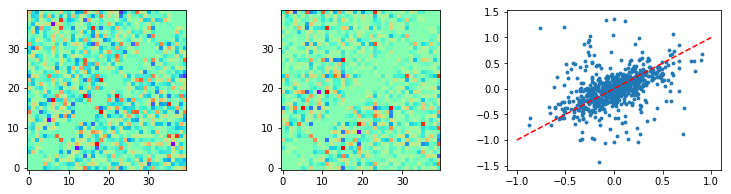

In [17]:
w_pred_2d = w_pred_2d + w_pred_2d.T

w0 = w_true
w = w_pred_2d

nx,ny = 3,1
nfig = nx*ny
fig, ax = plt.subplots(ny,nx,figsize=(nx*3.5,ny*2.8))

ax[0].imshow(w0,cmap='rainbow',origin='lower')

ax[1].imshow(w,cmap='rainbow',origin='lower')

ax[2].plot([-1,1],[-1,1],'r--')
ax[2].scatter(np.triu(w0),np.triu(w),s=8)

plt.tight_layout(h_pad=1, w_pad=1.5)
#plt.savefig('w.pdf', format='pdf', dpi=100)